<a href="https://colab.research.google.com/github/ZlatanSU87/Graduate-work.-Forecast-for-the-cafe-chain/blob/main/df_ml_cafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd

In [ ]:
# Установка необходимых библиотек (если не установлены)
!pip install optuna catboost lightgbm xgboost prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [ ]:
INPUT_CSV = '/kaggle/input/cafe_f_engin_EDA.csv'

In [ ]:
df= pd.read_csv(INPUT_CSV)
df.head(2)

,ts,Количество блюд,Тип оплаты,Торговое предприятие,"Сумма со скидкой, р.","Сумма без скидки, р.",Наценка(%),"Себестоимость, р.",Себестоимость(%),holiday_name,...,dow,is_weekend,precip_flag,rain_flag,snow_flag,t_bin,hot,cold,windy,icy_snow
0,2021-04-06 15:48:05+03:00,1,Наличные,Энгельса,60.0,60.0,1.1761,27.5725,0.4595,Рабочий день,...,1,0,1,1,0,0..5,0,0,1,0
1,2021-04-06 15:48:05+03:00,1,Наличные,Энгельса,90.0,90.0,1.5714,35.0000,0.3889,Рабочий день,...,1,0,1,1,0,0..5,0,0,1,0


Этап 2. Загрузка и базовая подготовка данных

In [ ]:
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath)
    # Преобразуем даты
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = pd.to_datetime(df['date'])
    # Сортировка по времени
    df = df.sort_values('ts')
    return df

In [ ]:
def handle_outliers(df, columns):
    """
    Обрезает выбросы по 1 и 99 перцентилю и создает флаговые признаки выбросов.
    df: DataFrame
    columns: список признаков для обработки
    """
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        # Флаг выброса
        df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)
        # Обрезка
        df[col] = df[col].clip(lower, upper)
    return df

Этап 3. Агрегация данных по нужным срезам

In [ ]:
def aggregate_data(df, group_by, target_cols, agg_funcs):
    """ group_by: list of columns (например, ['date', 'Торговое предприятие'])
    target_cols: list of columns to aggregate (например, ['Количество блюд', 'Сумма со скидкой, р.'])
    agg_funcs: dict, например {'Количество блюд': 'sum', 'Сумма со скидкой, р.': 'sum'} """
    agg_df = df.groupby(group_by)[target_cols].agg(agg_funcs).reset_index()
    return agg_df

In [ ]:
# Пример: агрегировать по дням и предприятиям
daily_enterprise = aggregate_data(df,
    ['date', 'Торговое предприятие'],
    ['Количество блюд', 'Сумма со скидкой, р.'],
    {'Количество блюд':'sum', 'Сумма со скидкой, р.':'sum'})

Этап 4. Подготовка данных для моделей

In [ ]:
def prepare_features(df, features, target, test_size=0.2, time_series=True):
    """ features: список признаков
    target: целевая переменная
    """
    X = df[features]
    y = df[target]
    if time_series:
      split_idx = int(len(df)*(1-test_size))
      X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
      y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test

Этап 5. Обёртки для моделей и Optuna

In [ ]:
def objective_lgbm(trial, X_train, y_train, X_valid, y_valid, cat_features):

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'random_state': 42,
        'verbose': -1  # Добавляем для подавления лишних сообщений
    }

    # Добавляем проверку на доступность GPU
    try:
        import torch
        params['device'] = 'gpu'
    except ImportError:
        print("GPU не доступен, используется CPU")

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
    valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features, free_raw_data=False)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(0)
        ]
    )
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def train_lgbm_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')

    objective_with_data = lambda trial: objective_lgbm(
        trial, X_train, y_train, X_valid, y_valid, cat_features
    )

    study.optimize(objective_with_data, n_trials=n_trials, show_progress_bar=True)

    # Обучаем финальную модель с лучшими параметрами
    best_params = study.best_params

    # Преобразуем категориальные признаки в правильный формат для LightGBM
    for feature in cat_features:
        X_train[feature] = X_train[feature].astype('category')
        X_valid[feature] = X_valid[feature].astype('category')

    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cat_features,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
    )

    return model, study


def objective_xgb(trial, X_train, y_train, X_valid, y_valid, cat_features):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'gpu_hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'random_state': 42,
    }
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    evals = [(dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    preds = model.predict(dvalid)
    return mean_absolute_error(y_valid, preds)

def train_xgb_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_valid, y_valid, cat_features), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'objective':'reg:squarederror', 'eval_metric':'rmse', 'tree_method':'gpu_hist', 'random_state':42})
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    evals = [(dvalid, 'eval')]
    model = xgb.train(best_params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=50, verbose_eval=False)
    return model, study

def objective_catboost(trial, X_train, y_train, X_valid, y_valid, cat_features):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'task_type': 'GPU'
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features, early_stopping_rounds=50)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

def train_catboost_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_catboost(trial, X_train, y_train, X_valid, y_valid, cat_features), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'loss_function':'RMSE', 'eval_metric':'RMSE', 'random_seed':42, 'task_type':'GPU'})
    model = CatBoostRegressor(**best_params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features, early_stopping_rounds=50)
    return model, study

def objective_prophet(trial, train_df, valid_df, regressors):
    params = { 'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
              'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True),
              'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True),
              'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
              'yearly_seasonality': True,
              'weekly_seasonality': True,
              'daily_seasonality': False,}
    model = Prophet(**params)
    # Добавляем регрессоры
    for reg in regressors:
      model.add_regressor(reg)
    model.fit(train_df)
    forecast = model.predict(valid_df[['ds'] + regressors])
    preds = forecast['yhat'].values
    return mean_absolute_error(valid_df['y'], preds)

def train_prophet_optuna(train_df, valid_df, regressors, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial:
                   objective_prophet(trial, train_df, valid_df, regressors), n_trials=n_trials)
    best_params = study.best_params
    best_params.update({'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False})
    model = Prophet(**best_params)
    for reg in regressors:
      model.add_regressor(reg)
    model.fit(train_df)
    return model, study

Этап 6. Оценка моделей и визуализация, важность признаков, предсказание на будущие периоды

In [ ]:
def evaluate_model(model, X_test, y_test, model_name='Model', model_type='sklearn', features=None):
    """ model_type: 'catboost', 'lgbm', 'xgb', 'prophet' features: список признаков (для xgb) """
    if model_type == 'prophet': # X_test должен содержать 'ds', 'y' и все регрессоры
        forecast = model.predict(X_test)
        preds = forecast['yhat'].values
        y_true = X_test['y'].values
    elif model_type == 'xgb':
        dtest = xgb.DMatrix(X_test[features], enable_categorical=True)
        preds = model.predict(dtest)
        y_true = y_test.values
    else:
        preds = model.predict(X_test)
        y_true = y_test.values

    mae = mean_absolute_error(y_true, preds)
    try:
      rmse = mean_squared_error(y_true, preds, squared=False)
    except TypeError:
      rmse = np.sqrt(mean_squared_error(y_true, preds))
    print(f'{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}')
    plt.figure(figsize=(12,4))
    plt.plot(y_true, label='True')
    plt.plot(preds, label='Predicted')
    plt.title(f'{model_name} - True vs Predicted')
    plt.legend()
    plt.show()
    return mae, rmse, preds

def plot_feature_importance(model, feature_names, model_type='catboost', top_n=20, save_path=None):
    if model_type == 'catboost':
        importances = model.get_feature_importance()
        importances = 100 * importances / importances.sum()
    elif model_type == 'lgbm':
        importances = model.feature_importances_
        importances = 100 * importances / importances.sum()
    elif model_type == 'xgb':
        score = model.get_score(importance_type='weight')
        # Используем реальные имена признаков!
        importances = np.array([score.get(f, 0) for f in feature_names])
        if importances.sum() > 0:
            importances = 100 * importances / importances.sum()
    else:
        print('Важность признаков не поддерживается для Prophet.')
        return
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[indices], importances[indices], color='skyblue')
    plt.xlabel('Важность признака (%)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.title(f'Важность признаков: {model_type}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    for i, v in enumerate(importances[indices]):
        plt.text(v, i, f'{v:.2f}%', va='center', fontsize=10)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

def predict_future(model, future_df, features, model_type='sklearn'):
    """ model_type: 'catboost', 'lgbm', 'xgb', 'sklearn' features: список признаков для предсказания """
    if model_type == 'xgb':
        dtest = xgb.DMatrix(future_df[features], enable_categorical=True)
        preds = model.predict(dtest)
    elif model_type == 'catboost':
        preds = model.predict(future_df[features])
    elif model_type == 'lgbm':
        preds = model.predict(future_df[features])
    else:
        # sklearn-like
        preds = model.predict(future_df[features])
    return preds

def predict_future_prophet(model, future_df):
    """ future_df должен содержать 'ds' и все регрессоры, которые использовались при обучении. """
    forecast = model.predict(future_df)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
class DemandRevenuePredictor:
    def init(self, df):
        self.df = df

    def aggregate(self, group_by, target_cols, agg_funcs):
        return aggregate_data(self.df, group_by, target_cols, agg_funcs)

    def train_model(self, X_train, y_train, X_valid, y_valid, cat_features=None, n_trials=20, model_type='catboost', regressors=None):
        if model_type == 'catboost':
            model, study = train_catboost_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'lgbm':
            model, study = train_lgbm_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'xgb':
            model, study = train_xgb_optuna(X_train, y_train, X_valid, y_valid, cat_features, n_trials)
        elif model_type == 'prophet':
            model, study = train_prophet_optuna(X_train, y_train, regressors, n_trials)
        else:
            raise ValueError("Unknown model_type")
        return model, study

    def evaluate(self, model, X_test, y_test, model_name='Model', model_type='catboost', features=None):
        return evaluate_model(model, X_test, y_test, model_name, model_type, features)

    def feature_importance(self, model, feature_names, model_type='catboost', top_n=20):
        plot_feature_importance(model, feature_names, model_type, top_n)

    def predict(self, model, future_df, features, model_type='catboost'):
        return predict_future(model, future_df, features, model_type)

    def predict_prophet(self, model, future_df):
        return predict_future_prophet(model, future_df)

In [ ]:
def sync_categories(X_train, X_test, cat_features):
    """Синхронизирует категориальные признаки между train и test"""
    X_train_sync = X_train.copy()
    X_test_sync = X_test.copy()
    real_cat_features = []
    cat_categories = {}
    for feature in cat_features:
        if feature in X_train.columns:
            train_cat = pd.Categorical(X_train[feature])
            test_cat = pd.Categorical(X_test[feature])
            all_categories = pd.concat([
                pd.Series(train_cat),
                pd.Series(test_cat)
            ]).astype('category').cat.categories
            X_train_sync[feature] = pd.Categorical(X_train[feature], categories=all_categories)
            X_test_sync[feature] = pd.Categorical(X_test[feature], categories=all_categories)
            real_cat_features.append(feature)
            cat_categories[feature] = all_categories
    return X_train_sync, X_test_sync, real_cat_features, cat_categories

from sklearn.model_selection import TimeSeriesSplit

def universal_pipeline(
    filepath, group_by, target_cols, agg_funcs, features, target,
    cat_features, regressors, n_trials=20, test_size=0.2, n_splits=5
):
    # 1. Загрузка и подготовка
    df = load_and_prepare_data(filepath)
    # a) Агрегация по нескольким признакам (например, дата и предприятие)
    agg_df = aggregate_data(df, group_by, target_cols, agg_funcs)
    agg_df = handle_outliers(agg_df, ['precip'])

    # e) Валидация: TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, test_idx in tscv.split(agg_df):
        X_train, X_test = agg_df.iloc[train_idx][features], agg_df.iloc[test_idx][features]
        y_train, y_test = agg_df.iloc[train_idx][target], agg_df.iloc[test_idx][target]

        # 2.1 Для LightGBM: синхронизируем категории
        X_train_sync, X_test_sync, real_cat_features, cat_categories = sync_categories(
            X_train, X_test, cat_features
        )

        # 2.2 Для XGBoost: просто приводим к category (без sync)
        X_train_xgb = X_train_sync.copy()
        X_test_xgb = X_test_sync.copy()
        for feature in real_cat_features:
            X_train_xgb[feature] = X_train_xgb[feature].cat.codes
            X_test_xgb[feature] = X_test_xgb[feature].cat.codes

        # Обучение моделей
        model_cat, study_cat = train_catboost_optuna(
            X_train_sync, y_train, X_test_sync, y_test, real_cat_features, n_trials
        )
        evaluate_model(model_cat, X_test_sync, y_test, model_name='CatBoost', model_type='catboost')

        model_lgbm, study_lgbm = train_lgbm_optuna(
            X_train_sync, y_train, X_test_sync, y_test, real_cat_features, n_trials
        )
        evaluate_model(model_lgbm, X_test_sync, y_test, model_name='LightGBM', model_type='lgbm')

        model_xgb, study_xgb = train_xgb_optuna(
            X_train_xgb, y_train, X_test_xgb, y_test, cat_features, n_trials
        )
        evaluate_model(model_xgb, X_test_xgb, y_test, model_name='XGBoost', model_type='xgb', features=features)

    # Prophet
    prophet_df = agg_df.rename(columns={target: 'y', group_by[0]: 'ds'})
    split_idx = int(len(prophet_df)*(1-test_size))
    train_df, valid_df = prophet_df.iloc[:split_idx], prophet_df.iloc[split_idx:]
    model_prophet, study_prophet = train_prophet_optuna(train_df, valid_df, regressors, n_trials)
    evaluate_model(model_prophet, valid_df, valid_df['y'], model_name='Prophet', model_type='prophet')

    # Прогнозирование на будущее для всех предприятий
    last_date = agg_df['date'].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=7, freq='D')
    enterprises = agg_df['Торговое предприятие'].unique()
    future_df = pd.DataFrame([
        {'date': date, 'Торговое предприятие': ent}
        for date in future_dates
        for ent in enterprises
    ])
    future_df['month'] = future_df['date'].dt.month
    future_df['dow'] = future_df['date'].dt.dayofweek
    future_df['season'] = ((future_df['month']%12 + 3)//3)
    for col in features:
        if col not in future_df.columns:
            future_df[col] = 0

    # Для Prophet
    future_prophet = future_df.rename(columns={'date': 'ds'})
    for reg in regressors:
        if reg not in future_prophet.columns:
            future_prophet[reg] = 0

    # --- СИНХРОНИЗАЦИЯ КАТЕГОРИЙ ДЛЯ future_df ---
    for f in real_cat_features:
        if f in future_df.columns:
            future_df[f] = pd.Categorical(future_df[f], categories=cat_categories[f])

    # Для XGBoost: преобразуем категории в коды
    future_df_xgb = future_df.copy()
    for f in real_cat_features:
        if f in future_df_xgb.columns:
            future_df_xgb[f] = pd.Categorical(future_df_xgb[f], categories=cat_categories[f])
            future_df_xgb[f] = future_df_xgb[f].cat.codes

    # Прогнозы
    preds_cat = predict_future(model_cat, future_df, features, model_type='catboost')
    preds_lgbm = predict_future(model_lgbm, future_df, features, model_type='lgbm')
    preds_xgb = predict_future(model_xgb, future_df_xgb, features, model_type='xgb')
    preds_prophet = predict_future_prophet(model_prophet, future_prophet)

    return {
        'catboost': model_cat,
        'lgbm': model_lgbm,
        'xgb': model_xgb,
        'prophet': model_prophet,
        'future_preds': {
            'catboost': preds_cat,
            'lgbm': preds_lgbm,
            'xgb': preds_xgb,
            'prophet': preds_prophet
        },
        'X_test_sync': X_test_sync,
        'X_test_xgb': X_test_xgb,
        'y_test': y_test,
        'valid_df': valid_df,
        'future_df': future_df
    }


In [ ]:
agg_funcs = {
    'Количество блюд': 'sum',
    'Сумма со скидкой, р.': 'sum',
    'is_holiday': 'max',
    't_mean': 'mean',
    't_max': 'max',
    't_min': 'min',
    'precip': 'sum',
    'snowfall_sum': 'sum',
    'wind_mean': 'mean',
    'humidity': 'mean',
    'is_weekend': 'max',
    'hot': 'sum',
    'cold': 'sum',
    'windy': 'sum',
    'icy_snow': 'sum',
    'month': 'first',
    'dow': 'first',
    'season': 'first'
}

features = [
    'Торговое предприятие',  # обязательно!
    'month', 'dow', 'season', 'is_holiday', 't_mean', 't_max', 't_min',
    'precip', 'snowfall_sum', 'wind_mean', 'humidity', 'is_weekend',
    'hot', 'cold', 'windy', 'icy_snow'
]

cat_features = [
    'Торговое предприятие', 'season', 'dow', 'is_holiday', 'is_weekend'
]

regressors = [
    'is_holiday', 't_mean', 'precip', 'wind_mean', 'humidity'
    # только те, которые реально есть в prophet_df
]

Вызов функции

[I 2025-10-27 17:23:20,623] A new study created in memory with name: no-name-b76c8120-253a-44dd-9284-037f3bb27712
[I 2025-10-27 17:23:22,252] Trial 0 finished with value: 437.04566273416685 and parameters: {'iterations': 688, 'depth': 6, 'learning_rate': 0.2511452263849485}. Best is trial 0 with value: 437.04566273416685.
[I 2025-10-27 17:23:28,316] Trial 1 finished with value: 424.49761773715386 and parameters: {'iterations': 889, 'depth': 9, 'learning_rate': 0.0933307266437348}. Best is trial 1 with value: 424.49761773715386.
[I 2025-10-27 17:23:29,941] Trial 2 finished with value: 358.93991344546095 and parameters: {'iterations': 181, 'depth': 4, 'learning_rate': 0.12295172002025338}. Best is trial 2 with value: 358.93991344546095.
[I 2025-10-27 17:23:38,111] Trial 3 finished with value: 429.69921599519705 and parameters: {'iterations': 544, 'depth': 9, 'learning_rate': 0.04703107226643509}. Best is trial 2 with value: 358.93991344546095.
[I 2025-10-27 17:23:44,948] Trial 4 finished

CatBoost - MAE: 345.57, RMSE: 510.26


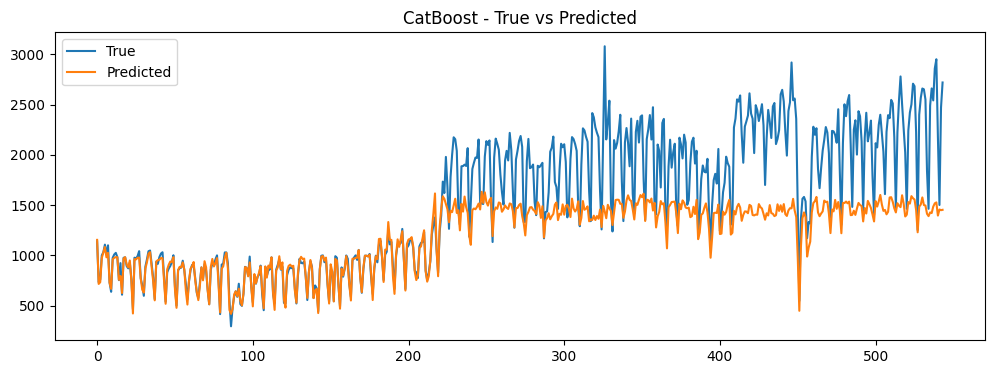

[I 2025-10-27 17:25:19,200] A new study created in memory with name: no-name-94168346-0458-48ac-a992-66515e65893c


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 576.653
[I 2025-10-27 17:25:19,574] Trial 0 finished with value: 393.39842763549774 and parameters: {'learning_rate': 0.21286007102588006, 'num_leaves': 85, 'max_depth': 6, 'feature_fraction': 0.8164282999196266, 'bagging_fraction': 0.6303533692190724, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 0 with value: 393.39842763549774.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's rmse: 682.907
[I 2025-10-27 17:25:19,945] Trial 1 finished with value: 483.96157132838005 and parameters: {'learning_rate': 0.13866998129144492, 'num_leaves': 29, 'max_depth': 11, 'feature_fraction': 0.798651917809746, 'bagging_fraction': 0.8186295309488707, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 0 with value: 393.39842763549774.
Training until validation scores don't improve f

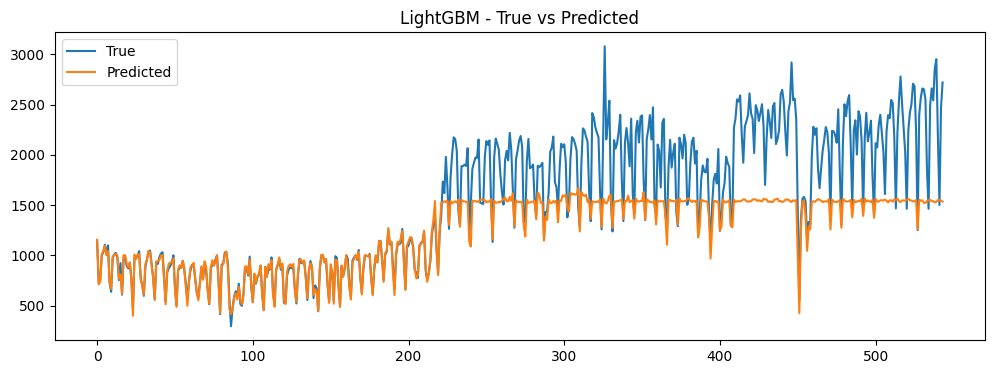

[I 2025-10-27 17:25:34,558] A new study created in memory with name: no-name-af7f0856-e76e-4706-85bc-7a2c040e8601
[I 2025-10-27 17:25:34,785] Trial 0 finished with value: 316.7242680156932 and parameters: {'learning_rate': 0.19291629934258428, 'max_depth': 5, 'subsample': 0.6023575615626039, 'colsample_bytree': 0.796359692431535, 'min_child_weight': 4, 'gamma': 0.05063876121126354, 'lambda': 0.3695974086666334, 'alpha': 0.0477652018575885}. Best is trial 0 with value: 316.7242680156932.
[I 2025-10-27 17:25:35,189] Trial 1 finished with value: 383.64348153507007 and parameters: {'learning_rate': 0.27835938899111085, 'max_depth': 6, 'subsample': 0.9560881026047359, 'colsample_bytree': 0.6760883981258317, 'min_child_weight': 15, 'gamma': 1.7976013027535642, 'lambda': 0.22886693413937795, 'alpha': 1.8159794291077709}. Best is trial 0 with value: 316.7242680156932.
[I 2025-10-27 17:25:35,982] Trial 2 finished with value: 397.87441500495464 and parameters: {'learning_rate': 0.109169390858832

XGBoost - MAE: 281.80, RMSE: 433.14


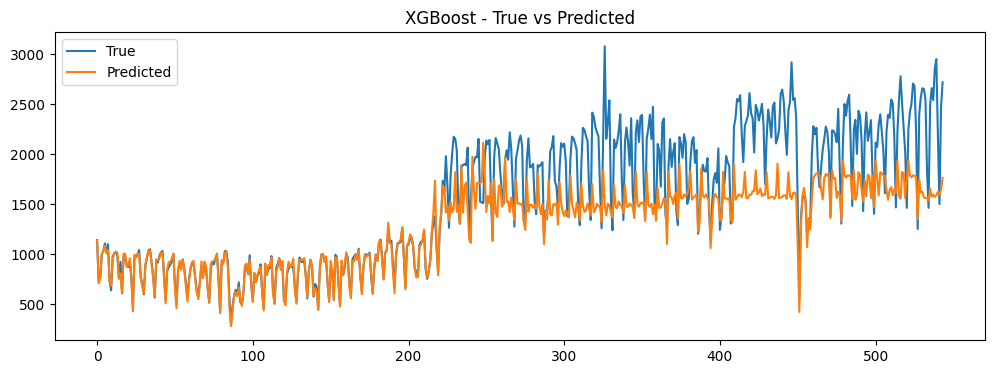

[I 2025-10-27 17:25:48,838] A new study created in memory with name: no-name-49b4af3b-8dd7-4edc-933c-d6fe5090a56f
[I 2025-10-27 17:25:51,112] Trial 0 finished with value: 49.27607547382906 and parameters: {'iterations': 165, 'depth': 7, 'learning_rate': 0.10618500016527929}. Best is trial 0 with value: 49.27607547382906.
[I 2025-10-27 17:25:54,374] Trial 1 finished with value: 34.456099095225746 and parameters: {'iterations': 522, 'depth': 7, 'learning_rate': 0.2749628638714676}. Best is trial 1 with value: 34.456099095225746.
[I 2025-10-27 17:25:58,405] Trial 2 finished with value: 30.09921834698393 and parameters: {'iterations': 476, 'depth': 4, 'learning_rate': 0.06443550911115133}. Best is trial 2 with value: 30.09921834698393.
[I 2025-10-27 17:26:00,786] Trial 3 finished with value: 37.956238123064395 and parameters: {'iterations': 981, 'depth': 7, 'learning_rate': 0.28764490112048563}. Best is trial 2 with value: 30.09921834698393.
[I 2025-10-27 17:26:06,107] Trial 4 finished wit

CatBoost - MAE: 27.58, RMSE: 41.36


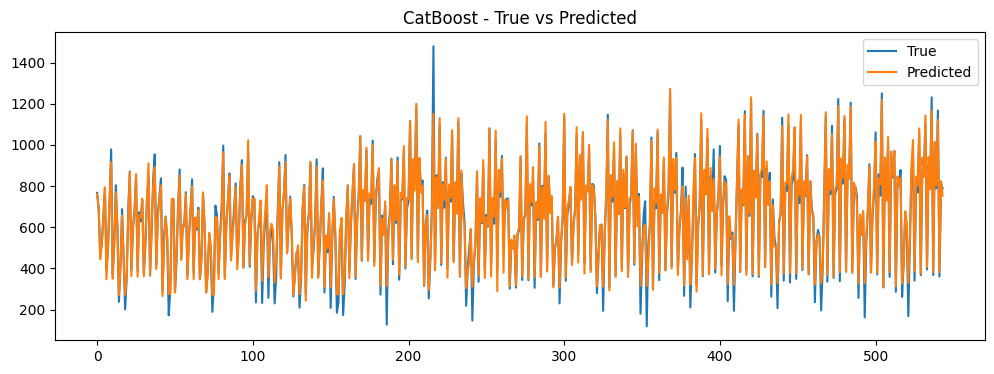

[I 2025-10-27 17:29:42,944] A new study created in memory with name: no-name-0ce4874e-4d64-48a0-98d6-d880a9ac619d


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 89.2254
[I 2025-10-27 17:29:43,330] Trial 0 finished with value: 61.60864159991667 and parameters: {'learning_rate': 0.23240409895631334, 'num_leaves': 75, 'max_depth': 9, 'feature_fraction': 0.7215881865851482, 'bagging_fraction': 0.6262177893423297, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 0 with value: 61.60864159991667.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 88.5927
[I 2025-10-27 17:29:43,700] Trial 1 finished with value: 60.27064694805401 and parameters: {'learning_rate': 0.28751252916054576, 'num_leaves': 62, 'max_depth': 12, 'feature_fraction': 0.7535680658447975, 'bagging_fraction': 0.6698257718787819, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 1 with value: 60.27064694805401.
Training until validation scores don't improve fo

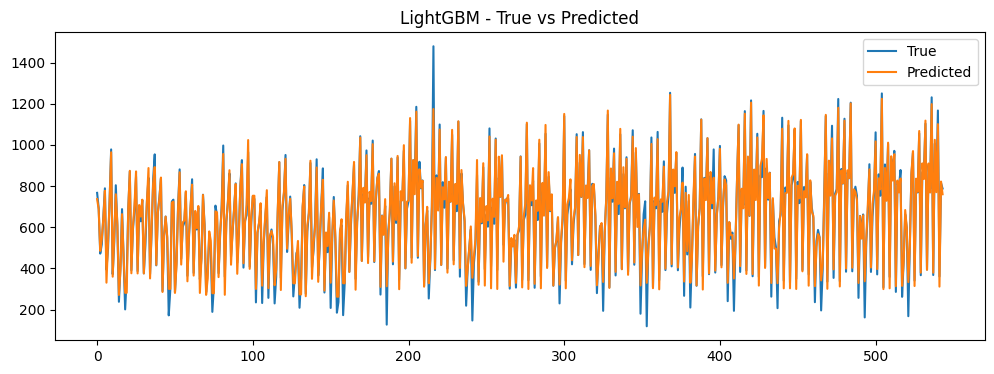

[I 2025-10-27 17:29:57,741] A new study created in memory with name: no-name-c231ea5d-e5f2-461c-96f0-288a4f0c4284
[I 2025-10-27 17:29:58,509] Trial 0 finished with value: 68.21553028331084 and parameters: {'learning_rate': 0.2586453391419972, 'max_depth': 7, 'subsample': 0.8338666388815618, 'colsample_bytree': 0.6945804543551712, 'min_child_weight': 14, 'gamma': 1.8108652192025714, 'lambda': 3.993064614917033, 'alpha': 0.16758409354204262}. Best is trial 0 with value: 68.21553028331084.
[I 2025-10-27 17:29:58,902] Trial 1 finished with value: 63.651393441592944 and parameters: {'learning_rate': 0.2530160600390771, 'max_depth': 6, 'subsample': 0.9544072983960036, 'colsample_bytree': 0.6478627524501889, 'min_child_weight': 9, 'gamma': 3.944056137207157, 'lambda': 0.002972702668198741, 'alpha': 0.0683398932916574}. Best is trial 1 with value: 63.651393441592944.
[I 2025-10-27 17:29:59,092] Trial 2 finished with value: 30.77170540304745 and parameters: {'learning_rate': 0.16231054329471706

XGBoost - MAE: 22.16, RMSE: 31.61


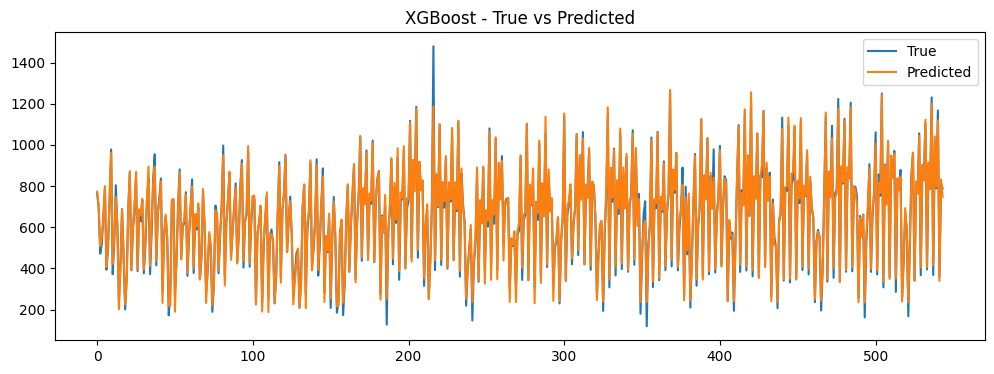

[I 2025-10-27 17:30:31,437] A new study created in memory with name: no-name-31c05539-47e8-462d-878f-03e9b3936c3c
[I 2025-10-27 17:30:34,177] Trial 0 finished with value: 29.659298303153907 and parameters: {'iterations': 331, 'depth': 4, 'learning_rate': 0.1556495298032349}. Best is trial 0 with value: 29.659298303153907.
[I 2025-10-27 17:30:37,825] Trial 1 finished with value: 22.67826144504333 and parameters: {'iterations': 774, 'depth': 5, 'learning_rate': 0.11416317039365109}. Best is trial 1 with value: 22.67826144504333.
[I 2025-10-27 17:30:56,734] Trial 2 finished with value: 22.265507526966818 and parameters: {'iterations': 519, 'depth': 10, 'learning_rate': 0.04964762391796897}. Best is trial 2 with value: 22.265507526966818.
[I 2025-10-27 17:30:58,795] Trial 3 finished with value: 47.885337932982914 and parameters: {'iterations': 919, 'depth': 5, 'learning_rate': 0.28901993987108643}. Best is trial 2 with value: 22.265507526966818.
[I 2025-10-27 17:31:02,408] Trial 4 finished

CatBoost - MAE: 20.84, RMSE: 30.44


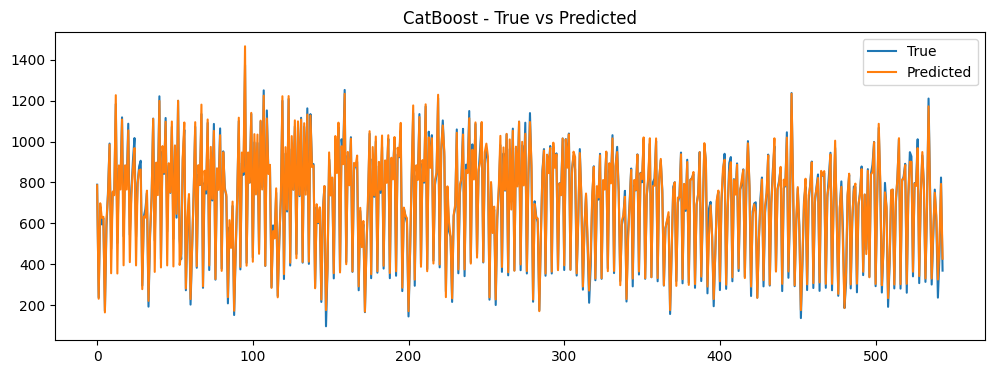

[I 2025-10-27 17:39:58,727] A new study created in memory with name: no-name-4d85a9db-5483-4c30-bdee-d5b55218aeca


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 28.0634
[I 2025-10-27 17:39:59,199] Trial 0 finished with value: 19.33638055459301 and parameters: {'learning_rate': 0.1993141394033579, 'num_leaves': 110, 'max_depth': 9, 'feature_fraction': 0.9672529658072375, 'bagging_fraction': 0.9566722471805356, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 0 with value: 19.33638055459301.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[58]	valid_0's rmse: 33.9163
[I 2025-10-27 17:39:59,468] Trial 1 finished with value: 22.861855370089458 and parameters: {'learning_rate': 0.08084941466713137, 'num_leaves': 79, 'max_depth': 8, 'feature_fraction': 0.9669835457015447, 'bagging_fraction': 0.6882980285082148, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 0 with value: 19.33638055459301.
Training until validation scores don't improve for 50 rounds
Did

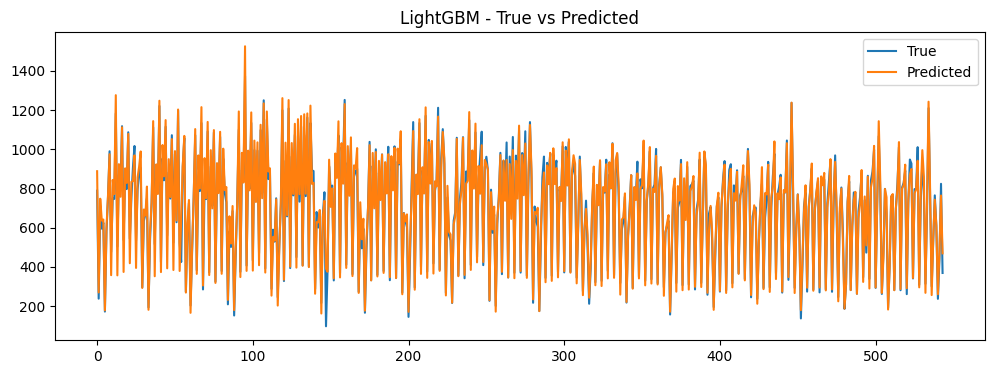

[I 2025-10-27 17:40:16,170] A new study created in memory with name: no-name-4d1b8073-ffdc-4fa6-9a0d-63d63232a071
[I 2025-10-27 17:40:16,748] Trial 0 finished with value: 20.319886039285098 and parameters: {'learning_rate': 0.08085662436798192, 'max_depth': 11, 'subsample': 0.9268834084030586, 'colsample_bytree': 0.9350901593350973, 'min_child_weight': 19, 'gamma': 1.6295078704310206, 'lambda': 0.031139281204474793, 'alpha': 0.03330156552437152}. Best is trial 0 with value: 20.319886039285098.
[I 2025-10-27 17:40:17,091] Trial 1 finished with value: 22.668129864860983 and parameters: {'learning_rate': 0.12395064328088948, 'max_depth': 8, 'subsample': 0.8942887480832651, 'colsample_bytree': 0.8640018893607988, 'min_child_weight': 12, 'gamma': 2.2446348628993795, 'lambda': 0.3336132312044076, 'alpha': 0.535309374752089}. Best is trial 0 with value: 20.319886039285098.
[I 2025-10-27 17:40:17,397] Trial 2 finished with value: 37.85674824434168 and parameters: {'learning_rate': 0.2985326321

XGBoost - MAE: 18.39, RMSE: 27.82


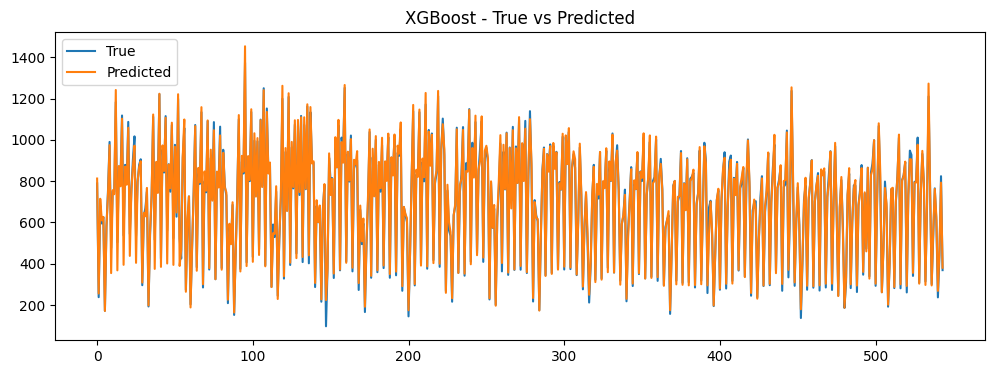

[I 2025-10-27 17:40:34,425] A new study created in memory with name: no-name-a277c94b-f19b-4614-9e4a-2c9b224583e1
[I 2025-10-27 17:40:35,862] Trial 0 finished with value: 22.175983121625368 and parameters: {'iterations': 159, 'depth': 4, 'learning_rate': 0.20503637237412017}. Best is trial 0 with value: 22.175983121625368.
[I 2025-10-27 17:40:38,297] Trial 1 finished with value: 20.8575192660856 and parameters: {'iterations': 407, 'depth': 4, 'learning_rate': 0.1969599961562516}. Best is trial 1 with value: 20.8575192660856.
[I 2025-10-27 17:40:43,663] Trial 2 finished with value: 23.996213055804994 and parameters: {'iterations': 661, 'depth': 6, 'learning_rate': 0.13026632710539743}. Best is trial 1 with value: 20.8575192660856.
[I 2025-10-27 17:41:26,651] Trial 3 finished with value: 25.90646552858691 and parameters: {'iterations': 877, 'depth': 10, 'learning_rate': 0.011310937819197477}. Best is trial 1 with value: 20.8575192660856.
[I 2025-10-27 17:41:28,336] Trial 4 finished with 

CatBoost - MAE: 19.98, RMSE: 28.72


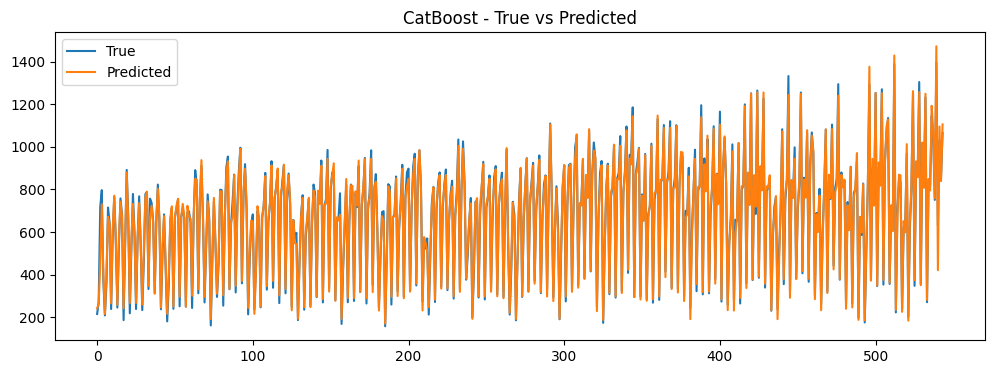

[I 2025-10-27 17:44:05,142] A new study created in memory with name: no-name-ceebe19d-758a-44c3-b211-bd416d5592dd


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's rmse: 27.7555
[I 2025-10-27 17:44:05,593] Trial 0 finished with value: 19.002548874257084 and parameters: {'learning_rate': 0.12487539647077726, 'num_leaves': 101, 'max_depth': 12, 'feature_fraction': 0.9726550873521976, 'bagging_fraction': 0.7408370467035462, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 0 with value: 19.002548874257084.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 51.971
[I 2025-10-27 17:44:05,829] Trial 1 finished with value: 37.82690382501688 and parameters: {'learning_rate': 0.11872739648342011, 'num_leaves': 53, 'max_depth': 4, 'feature_fraction': 0.6518137764977334, 'bagging_fraction': 0.7013367175113796, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 19.002548874257084.
Training until validation scores don't improve f

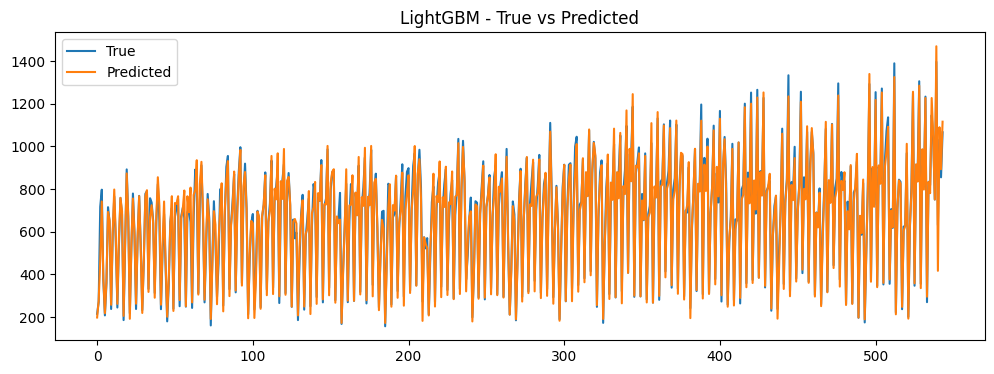

[I 2025-10-27 17:44:22,441] A new study created in memory with name: no-name-a4be0396-d63d-4791-b589-5c5924fd1f1c
[I 2025-10-27 17:44:22,805] Trial 0 finished with value: 21.525809231926413 and parameters: {'learning_rate': 0.20725622751015127, 'max_depth': 9, 'subsample': 0.6705880936894478, 'colsample_bytree': 0.8590966343074681, 'min_child_weight': 15, 'gamma': 2.605541733947046, 'lambda': 4.050452496813504, 'alpha': 0.047407538367772895}. Best is trial 0 with value: 21.525809231926413.
[I 2025-10-27 17:44:23,002] Trial 1 finished with value: 24.072113766389734 and parameters: {'learning_rate': 0.18407659169993135, 'max_depth': 5, 'subsample': 0.8788758375375942, 'colsample_bytree': 0.7999230952095402, 'min_child_weight': 2, 'gamma': 3.7223906622939724, 'lambda': 0.0016170802153686612, 'alpha': 0.721182192887606}. Best is trial 0 with value: 21.525809231926413.
[I 2025-10-27 17:44:25,958] Trial 2 finished with value: 32.006305021398205 and parameters: {'learning_rate': 0.02389220144

XGBoost - MAE: 18.38, RMSE: 27.34


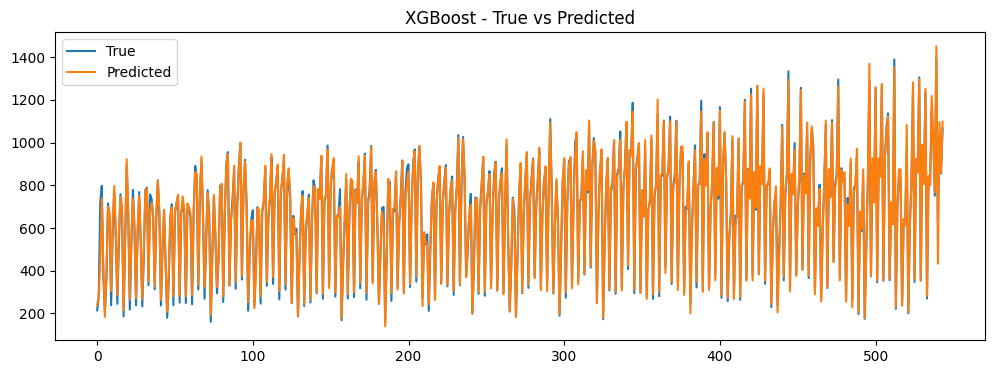

[I 2025-10-27 17:44:45,405] A new study created in memory with name: no-name-58781b89-281d-4ccf-a0a2-155c33ba83e0
[I 2025-10-27 17:44:47,085] Trial 0 finished with value: 27.427546233826433 and parameters: {'iterations': 472, 'depth': 5, 'learning_rate': 0.2950921796487267}. Best is trial 0 with value: 27.427546233826433.
[I 2025-10-27 17:44:51,503] Trial 1 finished with value: 24.41143056547201 and parameters: {'iterations': 218, 'depth': 8, 'learning_rate': 0.07374844404053986}. Best is trial 1 with value: 24.41143056547201.
[I 2025-10-27 17:44:57,612] Trial 2 finished with value: 30.222865459092787 and parameters: {'iterations': 993, 'depth': 6, 'learning_rate': 0.17912651970834495}. Best is trial 1 with value: 24.41143056547201.
[I 2025-10-27 17:45:02,121] Trial 3 finished with value: 26.941881762530368 and parameters: {'iterations': 991, 'depth': 8, 'learning_rate': 0.18906648405716517}. Best is trial 1 with value: 24.41143056547201.
[I 2025-10-27 17:45:10,348] Trial 4 finished wi

CatBoost - MAE: 22.31, RMSE: 30.69


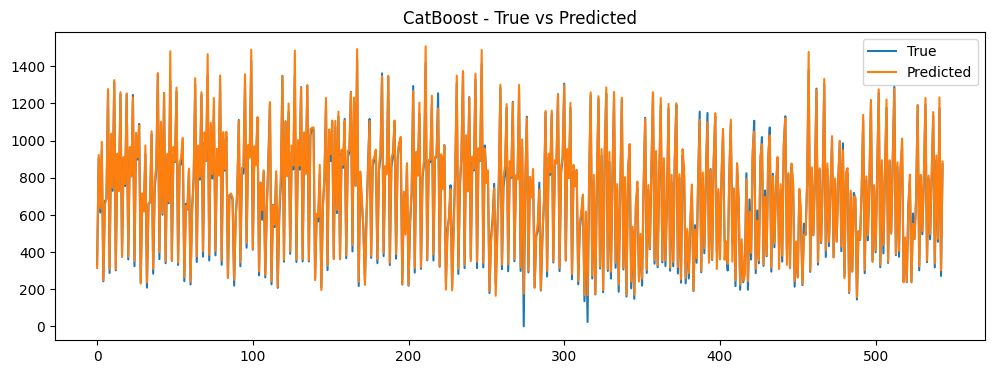

[I 2025-10-27 17:48:30,330] A new study created in memory with name: no-name-cb85cd08-e9db-42bd-a861-5ce739895244


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 42.7756
[I 2025-10-27 17:48:30,814] Trial 0 finished with value: 31.12726138265269 and parameters: {'learning_rate': 0.03712313448247703, 'num_leaves': 35, 'max_depth': 10, 'feature_fraction': 0.8415897983474077, 'bagging_fraction': 0.9286706380388174, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 0 with value: 31.12726138265269.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 59.5595
[I 2025-10-27 17:48:31,266] Trial 1 finished with value: 39.6964314450858 and parameters: {'learning_rate': 0.0794775864595311, 'num_leaves': 94, 'max_depth': 7, 'feature_fraction': 0.6590771890587116, 'bagging_fraction': 0.8519330918159576, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: 31.12726138265269.
Training until validation scores don't improve for 5

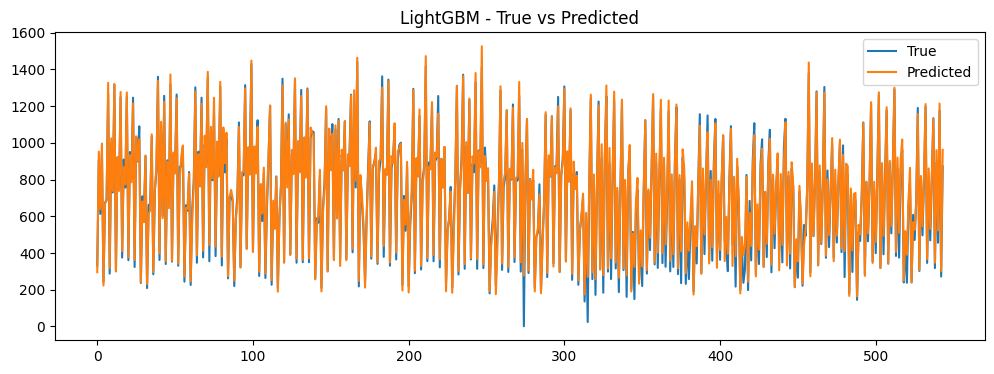

[I 2025-10-27 17:48:47,441] A new study created in memory with name: no-name-9d9e61b4-139a-42b5-a80f-04e2986e4471
[I 2025-10-27 17:48:47,749] Trial 0 finished with value: 26.427174231585333 and parameters: {'learning_rate': 0.1792924460364734, 'max_depth': 8, 'subsample': 0.85542864859507, 'colsample_bytree': 0.9390982238397502, 'min_child_weight': 15, 'gamma': 0.014037675258679605, 'lambda': 3.016955609986139, 'alpha': 0.3280771390627913}. Best is trial 0 with value: 26.427174231585333.
[I 2025-10-27 17:48:49,727] Trial 1 finished with value: 34.348661086138556 and parameters: {'learning_rate': 0.01011871579143604, 'max_depth': 5, 'subsample': 0.7798333884396822, 'colsample_bytree': 0.6565787338222839, 'min_child_weight': 11, 'gamma': 2.0848362422142035, 'lambda': 0.003349973232427432, 'alpha': 0.15307599956496465}. Best is trial 0 with value: 26.427174231585333.
[I 2025-10-27 17:48:50,070] Trial 2 finished with value: 28.161979338702032 and parameters: {'learning_rate': 0.15631500282

XGBoost - MAE: 22.72, RMSE: 31.70


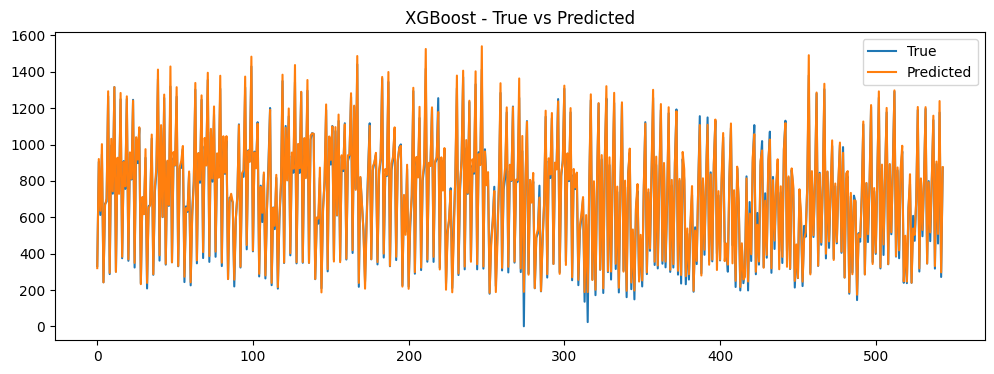

[I 2025-10-27 17:49:03,480] A new study created in memory with name: no-name-a23b0bba-5d66-43df-b20a-4cc19f270fa7
17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-27 17:49:04,631] Trial 0 finished with value: 388.9754557170094 and parameters: {'changepoint_prior_scale': 0.07051539002970897, 'seasonality_prior_scale': 0.0103839234188859, 'holidays_prior_scale': 0.060025681284323035, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 388.9754557170094.
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-27 17:49:05,193] Trial 1 finished with value: 380.54128272960526 and parameters: {'changepoint_prior_scale': 0.009932442650445518, 'seasonality_prior_scale': 0.807309131856336, 'holidays_prior_scale': 0.815448149427887, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 380.54128272960526.
17:49:05 - cmdstanpy - INFO -

Prophet - MAE: 268.65, RMSE: 322.64


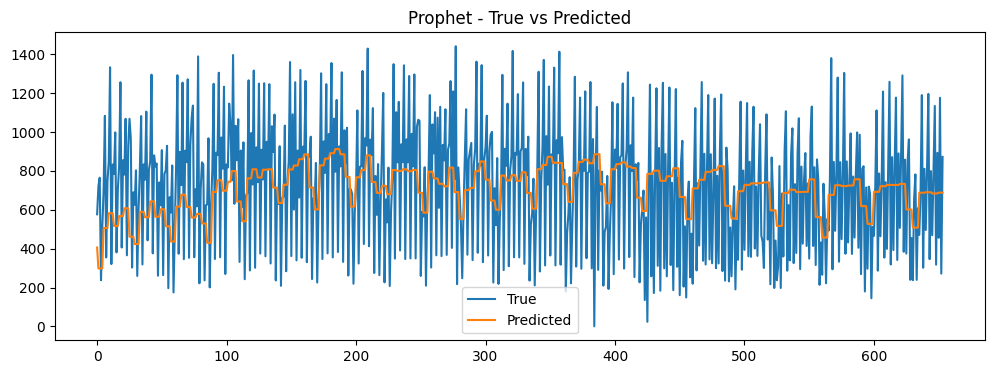

In [ ]:
# Пример вызова:
models = universal_pipeline(
    filepath=INPUT_CSV,
    group_by=['date', 'Торговое предприятие'],
    target_cols=list(agg_funcs.keys()),
    agg_funcs=agg_funcs,
    features=features,
    target='Количество блюд',
    cat_features=cat_features,
    regressors=regressors,
    n_trials=40,
    test_size=0.2,
    n_splits=5)

      Model         MAE        RMSE
0  CatBoost   22.310267   30.694928
1  LightGBM   34.754877   48.325902
2   XGBoost   22.719739   31.696479
3   Prophet  268.654126  322.641736


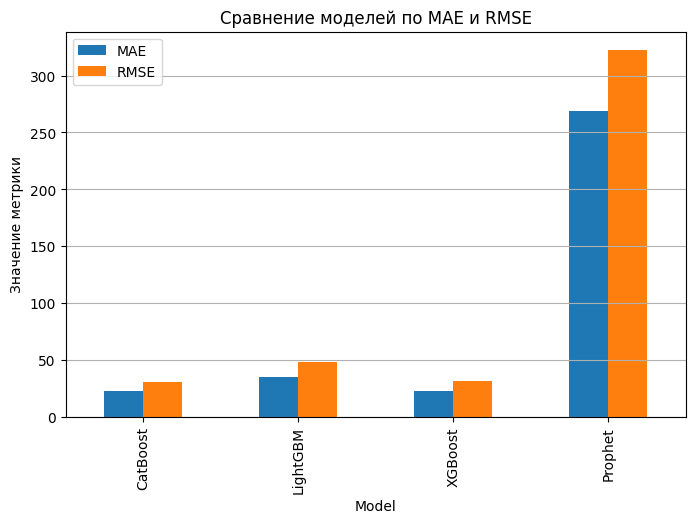

In [ ]:
future_preds = models['future_preds']

# Если вы хотите сравнить на тестовой выборке:
# y_test — реальные значения, X_test_sync — тестовые признаки (или valid_df['y'] для Prophet)
# Предполагаем, что у вас есть y_test и valid_df['y']

# Получаем предсказания на тестовой выборке
y_test = models['y_test']
X_test_sync = models['X_test_sync']
preds_cat = models['catboost'].predict(X_test_sync)
preds_lgbm = models['lgbm'].predict(X_test_sync)
X_test_xgb = models['X_test_xgb']
dtest = xgb.DMatrix(X_test_xgb)
preds_xgb = models['xgb'].predict(dtest)
valid_df = models['valid_df']
preds_prophet = models['prophet'].predict(valid_df)['yhat']  # valid_df — валидационная выборка для Prophet

# Считаем метрики
results = []
results.append({
    'Model': 'CatBoost',
    'MAE': mean_absolute_error(y_test, preds_cat),
    'RMSE': mean_squared_error(y_test, preds_cat, squared=False)
})
results.append({
    'Model': 'LightGBM',
    'MAE': mean_absolute_error(y_test, preds_lgbm),
    'RMSE': mean_squared_error(y_test, preds_lgbm, squared=False)
})
results.append({
    'Model': 'XGBoost',
    'MAE': mean_absolute_error(y_test, preds_xgb),
    'RMSE': mean_squared_error(y_test, preds_xgb, squared=False)
})
results.append({
    'Model': 'Prophet',
    'MAE': mean_absolute_error(valid_df['y'], preds_prophet),
    'RMSE': mean_squared_error(valid_df['y'], preds_prophet, squared=False)
})

# Таблица сравнения
results_df = pd.DataFrame(results)
print(results_df)

# График сравнения
results_df.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(8, 5))
plt.title('Сравнение моделей по MAE и RMSE')
plt.ylabel('Значение метрики')
plt.grid(axis='y')
plt.show()

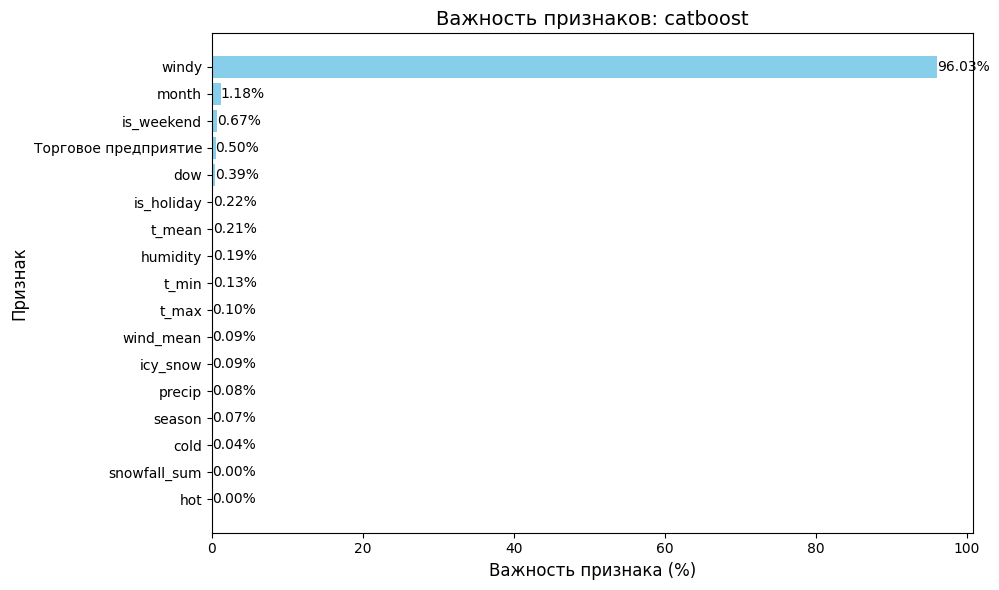

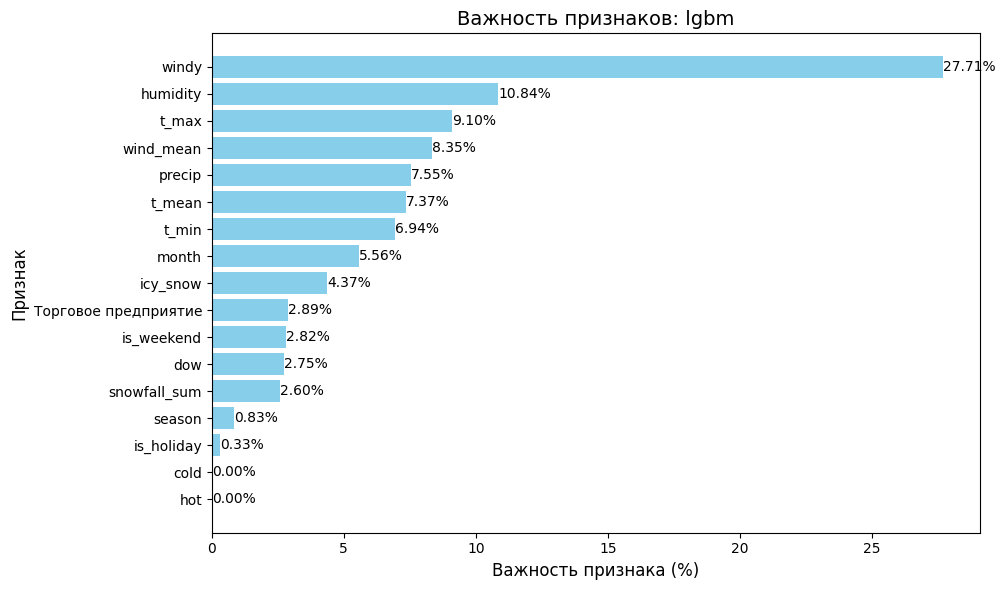

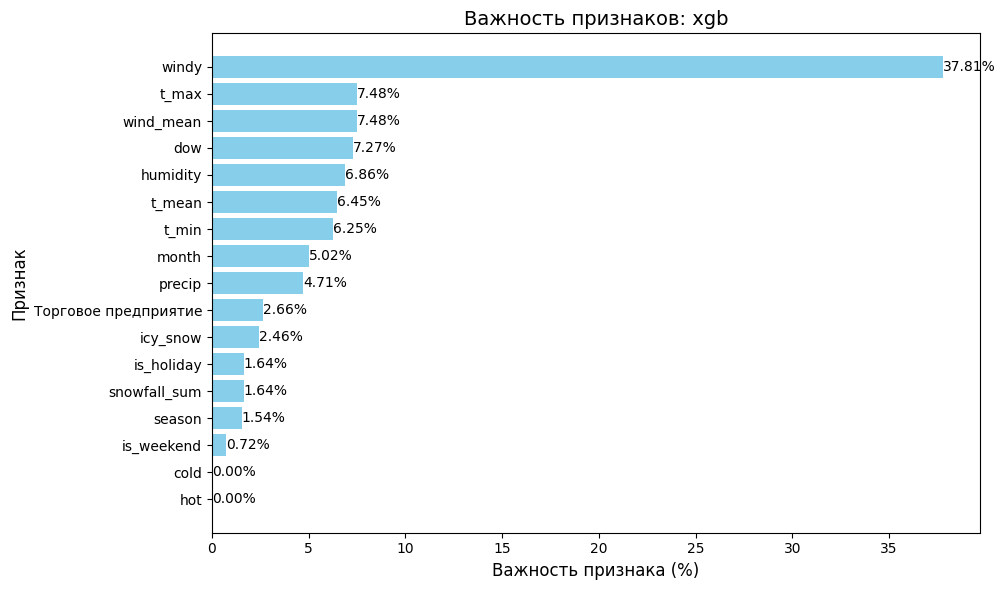

In [ ]:
plot_feature_importance(models['catboost'], features, model_type='catboost', save_path='catboost_importance.png')
plot_feature_importance(models['lgbm'], features, model_type='lgbm', save_path='lgbm_importance.png')
plot_feature_importance(models['xgb'], features, model_type='xgb', save_path='xgb_importance.png')

In [ ]:
# Сопоставление имён моделей
model_name_map = {
    'catboost': 'catboost',
    'lightgbm': 'lgbm',
    'xgboost': 'xgb',
    'prophet': 'prophet'
}

best_model_name = results_df.sort_values('MAE').iloc[0]['Model'].lower()
best_model_key = model_name_map[best_model_name]

future_df = models['future_df']
future_preds = models['future_preds'][best_model_key]

future_table = future_df[['Торговое предприятие', 'date']].copy()
future_table['prediction'] = future_preds

print(future_table)

   Торговое предприятие       date  prediction
0              Энгельса 2025-09-19  173.607582
1                 Плаза 2025-09-19  184.387474
2             Свердлова 2025-09-19  175.913651
3                Тетрис 2025-09-19  175.169184
4               Анохина 2025-09-19  173.712719
5              Энгельса 2025-09-20  176.803874
6                 Плаза 2025-09-20  184.543109
7             Свердлова 2025-09-20  179.412074
8                Тетрис 2025-09-20  175.324819
9               Анохина 2025-09-20  177.101233
10             Энгельса 2025-09-21  186.192102
11                Плаза 2025-09-21  184.875258
12            Свердлова 2025-09-21  188.641016
13               Тетрис 2025-09-21  175.656968
14              Анохина 2025-09-21  179.598112
15             Энгельса 2025-09-22  172.137831
16                Плаза 2025-09-22  181.936792
17            Свердлова 2025-09-22  174.443900
18               Тетрис 2025-09-22  172.718502
19              Анохина 2025-09-22  172.435190
20           

1. Сохранение лучшей модели

In [ ]:
best_model = models[best_model_key]

# CatBoost
if best_model_key == 'catboost':
    best_model.save_model('best_catboost.cbm')

# LightGBM
elif best_model_key == 'lgbm':
    best_model.booster_.save_model('best_lgbm.txt')

# XGBoost
elif best_model_key == 'xgb':
    best_model.save_model('best_xgb.model')

# Prophet
elif best_model_key == 'prophet':
    import joblib
    joblib.dump(best_model, 'best_prophet.pkl')

2. Загрузка модели

In [ ]:
# CatBoost
if best_model_key == 'catboost':
    from catboost import CatBoostRegressor
    loaded_model = CatBoostRegressor()
    loaded_model.load_model('best_catboost.cbm')

# LightGBM
elif best_model_key == 'lgbm':
    import lightgbm as lgb
    loaded_model = lgb.Booster(model_file='best_lgbm.txt')

# XGBoost
elif best_model_key == 'xgb':
    import xgboost as xgb
    loaded_model = xgb.Booster()
    loaded_model.load_model('best_xgb.model')

# Prophet
elif best_model_key == 'prophet':
    import joblib
    loaded_model = joblib.load('best_prophet.pkl')

3. Использование загруженной модели для предсказания

In [ ]:
# Для CatBoost и LightGBM (sklearn API)
if best_model_key == 'catboost':
    preds = loaded_model.predict(future_df[features])
elif best_model_key == 'lgbm':
    preds = loaded_model.predict(future_df[features])

# Для XGBoost (низкоуровневый API)
elif best_model_name == 'xgb':
    dmatrix = xgb.DMatrix(future_df[features])
    preds = loaded_model.predict(dmatrix)

# Для Prophet
elif best_model_name == 'prophet':
    preds = loaded_model.predict(future_df.rename(columns={'date': 'ds'}))['yhat']

# Формируем таблицу
future_table = future_df[['Торговое предприятие', 'date']].copy()
future_table['prediction'] = preds
print(future_table)

   Торговое предприятие       date  prediction
0              Энгельса 2025-09-19  173.607582
1                 Плаза 2025-09-19  184.387474
2             Свердлова 2025-09-19  175.913651
3                Тетрис 2025-09-19  175.169184
4               Анохина 2025-09-19  173.712719
5              Энгельса 2025-09-20  176.803874
6                 Плаза 2025-09-20  184.543109
7             Свердлова 2025-09-20  179.412074
8                Тетрис 2025-09-20  175.324819
9               Анохина 2025-09-20  177.101233
10             Энгельса 2025-09-21  186.192102
11                Плаза 2025-09-21  184.875258
12            Свердлова 2025-09-21  188.641016
13               Тетрис 2025-09-21  175.656968
14              Анохина 2025-09-21  179.598112
15             Энгельса 2025-09-22  172.137831
16                Плаза 2025-09-22  181.936792
17            Свердлова 2025-09-22  174.443900
18               Тетрис 2025-09-22  172.718502
19              Анохина 2025-09-22  172.435190
20           